# Постановка задачи

Пусть дан ориентированный граф $G = (V, E, L)$. Каждому пути $l = l_1, \dots, l_n$ в этом графе сопоставим слово $\omega(l) = m_1 \dots m_n$, полученное конкатенацией меток $m_i$, где $m_i$ -- метка ребра $l_i$. Также пусть даны два множества: $V_s \subseteq V$ -- множество стартовых вершин в графе и $V_f \subseteq V$ -- множество финальных вершин в графе.

Пусть через регулярное выражение задан регулярный язык $R$.

## Достижимость между всеми парами вершин

$\{ (v_s, v_f) \in V \times V : \exists l = v_s \pi v_f, ~\omega(l) \in R \}$

## Достижимость для каждой из заданного множества стартовых вершин

$\{ (v_s, v_f) \in V_s \times V_f : \exists l = v_s \pi v_f, ~\omega(l) \in R \}$

Целью эксперимента является получить ответ на следующие вопросы:

1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

# Описание исследуемых решений

## Достижимость между всеми парами вершин

Задача о достижимости между всеми парами вершин решается при помощи алгоритма на основе тензорного произведения матриц (`tensor_based_rpq`): по регулярному выражению и графу строятся два автомата на основе матриц смежности, при помощи тензорного произведения ищется пересечение этих автоматов и при помощи транзитивного замыкания полученного пересечения ищутся необходимые пары вершин.

## Достижимость для каждой из заданного множества стартовых вершин

Задача о достижимости для каждой из заданного множества стартовых вершин решается при помощи multiple source BFS алгоритма (`ms_bfs_based_rpq`): по регулярному выражению и графу строятся два автомата на основе матриц смежности, а затем по ним параллельно из всех стартовых вершин совершается обход в ширину.

# Описание набора данных для экспериментов

В качестве эспериментальных графов были выбраны следующие:
1. `skos`
2. `wc`
3. `generations`
4. `atom`


| Граф        | Количество вершин | Количество ребер |
|-------------|-------------------|------------------|
| skos        | 144               | 252              |
| wc          | 332               | 269              |
| generations | 129               | 273              |
| atom        | 291               | 425              |

Выбор подобных графов обусловлен важностью рассмотреть различные конфигурации графов (по количеству вершин, ребер и меток) в условиях ограничения тестового стенда. 

Пронумеруем метки в графе таким образом, чтобы `m_1` обозначало самую частую, а `m_n` -- самую редкую метку. Тогда в качестве шаблонов для регулярных запросов были выбраны следующие:
1. `m_1 | m_2 | ... | m_n` -- все пути в графе длины 1
2. `(m_1 | m_2 | ... | m_n)*` -- все пути в графе
3. `m_1 . (m_1 | ... | m_n)* . m_n` -- пути, начинающиеся самой частой и заканчивающиеся самой редкой меткой
4. `(m_1 | m_2)* . ((m_1* . m_2*) | (m_2* . m_1*))`

Выбор запросов обусловлен тем, что они различаются по количеству состояний и переходов в конечном автомате, что влияет на размер и разреженность матрицы смежности.

В качестве рассматриваемых типов представления разреженной матрицы выбрались следующие:
1. `csr`
2. `csc`
3. `dok`

Выбор этих форматов разреженных матриц обусловлен тем, что только они поддерживают необходимые для работы описанных выше алгоритмов операции, к примеру как присваивание и взятие по индексу.

In [26]:
import networkx as nx
import pandas as pd
import numpy as np
import cfpq_data
import matplotlib.pyplot as plt
import seaborn as sns

from timeit import timeit

from utils import get_graph_info, load_graph
from regular.path_query import tensor_based_rpq, ms_bfs_based_rpq

pd.set_option("display.max_rows", None)

In [2]:
def get_sorted_labels(graph: nx.MultiDiGraph):
    labels = {}
    for _, _, label in graph.edges.data("label"):
        labels[label] = labels.get(label, 0) + 1

    return sorted(labels.keys(), key=lambda label: labels[label], reverse=True)

In [8]:
graph_names = ["skos", "wc", "generations", "atom"]
sparse_types = ["csr", "csc", "dok"]

regexes_templates = [
    "m_1 | m_2 | ... | m_n",
    "(m_1 | m_2 | ... | m_n)*",
    "m_1 . (m_1 | ... | m_n)* . m_n",
    "(m_1 | m_2)* . ((m_1* . m_2*) | (m_2* . m_1*))",
]


def get_regexes_by_graph(graph: nx.MultiDiGraph):
    labels = get_sorted_labels(graph)
    graph.edges
    return [
        "|".join(labels),
        f"({"|".join(labels)})*",
        f"{labels[0]}.({"|".join(labels)}).{labels[-1]}",
        f"({labels[0]}|{labels[1]})*.(({labels[0]}*.{labels[1]}*)|({labels[1]}*.{labels[0]}*))",
    ]

Графы содержат следующие метки:

In [ ]:
graphs = [(load_graph(graph_name), graph_name) for graph_name in graph_names]

In [80]:
for graph, name in graphs:
    print(f"{name}:", *[f"\t'{label}'" for label in get_sorted_labels(graph)], sep="\n")

skos:
	'type'
	'label'
	'definition'
	'isDefinedBy'
	'subPropertyOf'
	'comment'
	'scopeNote'
	'inverseOf'
	'range'
	'domain'
	'contributor'
	'disjointWith'
	'creator'
	'example'
	'first'
	'rest'
	'seeAlso'
	'title'
	'description'
	'unionOf'
	'subClassOf'
wc:
	'd'
	'a'
generations:
	'type'
	'rest'
	'first'
	'onProperty'
	'intersectionOf'
	'equivalentClass'
	'someValuesFrom'
	'hasValue'
	'hasSex'
	'inverseOf'
	'sameAs'
	'hasParent'
	'hasChild'
	'range'
	'hasSibling'
	'versionInfo'
	'oneOf'
atom:
	'type'
	'label'
	'subClassOf'
	'comment'
	'domain'
	'range'
	'subPropertyOf'
	'creator'
	'seeAlso'
	'title'
	'description'
	'imports'
	'date'
	'versionInfo'
	'language'
	'publisher'
	'format'


# Описание эксперимента

## Тестовый стенд

## Методология проведения эксперимента

### Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

Для каждого из алгоритмов и графов считалось среднее по 25 запускам время работы на различных типах разреженных матриц с регулярный запросом вида `(m_1 | m_2 | ... | m_n)*`. Затем для каждого типа разреженноы матриц считалось среднее время работы для всех проведенных замеров. В качестве стартовых и финальных вершин  выбирались все вершины графа.

### Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

В качестве расматриваемых размеров стартовых множеств брались 0.1, 0.3, 0.7 и 1 от числа вершин в графе. Выбор таких размеров обусловлен возможностью исследовать наибольший диапозон значений размеров стартовых вершин за разумное время. Для каждого алгоритма брался фиксированный тип разреженной матрицы (`csr`). Затем для каждого типа регулярного выражения из описанных выше, для каждого графа и для каждого размера стартового множества считалось среднее время работы по 25 запускам для двух алгоритмов. После считалась разность между `ms_bfs_based_rpq` и `tensor_based_rpq`. Для тех замеров, где эта разность оказывалась больше нуля, выгоднее было решать задачу для всех пар вершин.

# Эксперимент

In [30]:
NUM_RUNS = 25
RANDOM_SEED = 52

## Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

In [5]:
columns = ["graph"] + sparse_types

In [ ]:
results = {
    "tensors": {graph_name: [] for graph_name in graph_names},
    "ms_bfs": {graph_name: [] for graph_name in graph_names},
}

for graph_name in graph_names:
    graph = load_graph(graph_name)
    regex = get_regexes_by_graph(graph)[2]
    for sparse_type in sparse_types:
        print(sparse_type)
        times = {"tensors": [], "ms_bfs": []}
        for _ in range(NUM_RUNS):
            times["tensors"].append(
                timeit(
                    lambda: tensor_based_rpq(regex, graph, sparse_format=sparse_type),
                    number=1,
                )
            )
            times["ms_bfs"].append(
                timeit(
                    lambda: ms_bfs_based_rpq(regex, graph, sparse_format=sparse_type),
                    number=1,
                )
            )
        results["tensors"][graph_name].append(
            (np.mean(times["tensors"]), np.std(times["tensors"]))
        )
        results["ms_bfs"][graph_name].append(
            (np.mean(times["ms_bfs"]), np.std(times["ms_bfs"]))
        )

In [12]:
tensor_df = pd.DataFrame(
    [
        [graph_name] + list(map(lambda x: f"{x[0]:.3f} +- {x[1]:.3f}", res))
        for graph_name, res in results["tensors"].items()
    ],
    columns=columns,
)

In [14]:
print("Результаты для tensor_based_rpq")
tensor_df

Результаты для tensor_based_rpq


,graph,csr,csc,dok
0,skos,2.233 +- 0.124,2.222 +- 0.106,2.215 +- 0.131
1,wc,37.203 +- 0.355,37.150 +- 0.176,37.095 +- 0.076
2,generations,2.273 +- 0.024,2.285 +- 0.022,2.278 +- 0.023
3,atom,8.454 +- 0.053,8.595 +- 0.027,8.507 +- 0.047


In [15]:
ms_bfs_df = pd.DataFrame(
    [
        [graph_name] + list(map(lambda x: f"{x[0]:.3f} +- {x[1]:.3f}", res))
        for graph_name, res in results["ms_bfs"].items()
    ],
    columns=columns,
)

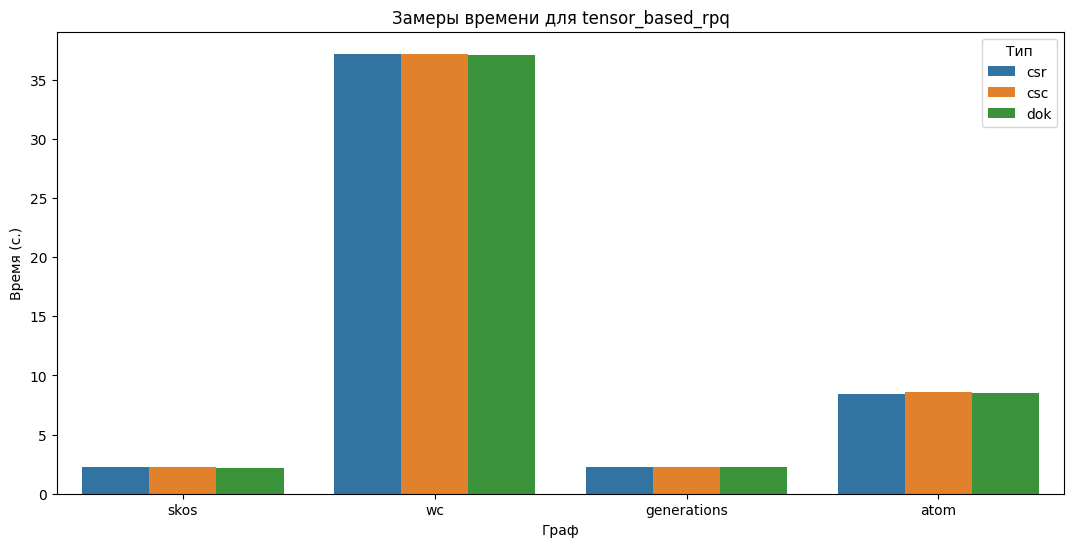

In [58]:
plot_tensor_df = pd.DataFrame(
    [
        [graph_name] + list(map(lambda x: x[0], res))
        for graph_name, res in results["tensors"].items()
    ],
    columns=columns,
).melt(id_vars=["graph"], value_vars=sparse_types, var_name="type", value_name="value")


plt.figure(figsize=(13, 6))
sns.barplot(data=plot_tensor_df, x="graph", y="value", hue="type")
plt.xlabel("Граф")
plt.ylabel("Время (с.)")
plt.title("Замеры времени для tensor_based_rpq")
plt.legend(title="Тип")
plt.show()

In [16]:
print("Результаты для ms_bfs_based_rpq")
ms_bfs_df

Результаты для ms_bfs_based_rpq


,graph,csr,csc,dok
0,skos,1.029 +- 0.026,1.019 +- 0.042,1.190 +- 0.036
1,wc,0.514 +- 0.013,0.523 +- 0.016,0.614 +- 0.017
2,generations,1.364 +- 0.032,1.352 +- 0.031,1.617 +- 0.023
3,atom,1.626 +- 0.042,1.626 +- 0.050,1.945 +- 0.047


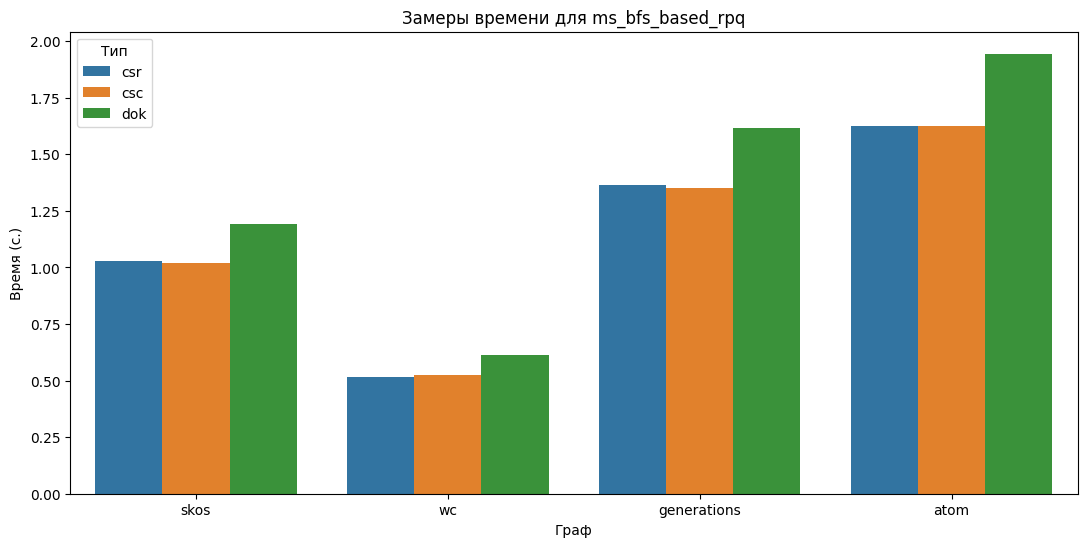

In [59]:
plot_ms_bfs_df = pd.DataFrame(
    [
        [graph_name] + list(map(lambda x: x[0], res))
        for graph_name, res in results["ms_bfs"].items()
    ],
    columns=columns,
).melt(id_vars=["graph"], value_vars=sparse_types, var_name="type", value_name="value")


plt.figure(figsize=(13, 6))
sns.barplot(data=plot_ms_bfs_df, x="graph", y="value", hue="type")
plt.xlabel("Граф")
plt.ylabel("Время (с.)")
plt.title("Замеры времени для ms_bfs_based_rpq")
plt.legend(title="Тип")
plt.show()

Из таблиц и графиков видно, что для `tensor_based_rpq` не играет большой разницы, какой формат представления разреженной матрицы брать. Однако для `ms_bfs_based_rpq` представление в формате `dok` снижает производительность по отношению к `csr` и `csc`, поэтому не рекомендуется его использовать.

## Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

In [5]:
columns = [
    "graph",
    "regex",
    "start set size",
    "tensor_based time",
    "ms_bfs time",
    "time diff",
]

In [6]:
sizes_multipliers = [0.1, 0.4, 0.7, 1]

In [14]:
results = {
    (graph_name, regex_idx, size_mul): {
        "tensors": None,
        "ms_bfs": None,
        "time_diff": None,
    }
    for graph_name in graph_names
    for regex_idx in range(4)
    for size_mul in sizes_multipliers
}

In [ ]:
for graph_name, regex_idx, size_mul in results:
    print(graph_name, regex_idx, size_mul)
    graph = load_graph(graph_name)
    regex = get_regexes_by_graph(graph)[regex_idx]
    start_set = cfpq_data.generate_multiple_source(
        graph,
        int(graph.number_of_nodes() * size_mul),
        seed=RANDOM_SEED,
    )
    times = {"tensors": [], "ms_bfs": []}

    for _ in range(NUM_RUNS):
        times["tensors"].append(
            timeit(lambda: tensor_based_rpq(regex, graph, start_set), number=1)
        )
        times["ms_bfs"].append(
            timeit(lambda: ms_bfs_based_rpq(regex, graph, start_set), number=1)
        )

    results[(graph_name, regex_idx, size_mul)]["tensors"] = (
        np.mean(times["tensors"]),
        np.std(times["tensors"]),
    )
    results[(graph_name, regex_idx, size_mul)]["ms_bfs"] = (
        np.mean(times["ms_bfs"]),
        np.std(times["ms_bfs"]),
    )

    time_diffs = [times["ms_bfs"][i] - times["tensors"][i] for i in range(NUM_RUNS)]
    results[(graph_name, regex_idx, size_mul)]["time_diff"] = (
        np.mean(time_diffs),
        np.std(time_diffs),
    )

In [32]:
df = pd.DataFrame(
    [
        [k[0], regexes_templates[k[1]], k[2]]
        + list(
            map(
                lambda x: f"{x[0]:.3f} +- {x[1]:.3f}",
                [v["tensors"], v["ms_bfs"], v["time_diff"]],
            )
        )
        for k, v in results.items()
    ],
    columns=columns,
)

In [33]:
df

,graph,regex,start set size,tensor_based time,ms_bfs time,time diff
0,skos,m_1 | m_2 | ... | m_n,0.1,0.057 +- 0.002,0.105 +- 0.004,0.047 +- 0.003
1,skos,m_1 | m_2 | ... | m_n,0.4,0.101 +- 0.002,0.371 +- 0.009,0.270 +- 0.008
2,skos,m_1 | m_2 | ... | m_n,0.7,0.165 +- 0.002,0.671 +- 0.018,0.506 +- 0.018
3,skos,m_1 | m_2 | ... | m_n,1.0,0.254 +- 0.003,1.002 +- 0.032,0.748 +- 0.032
4,skos,(m_1 | m_2 | ... | m_n)*,0.1,0.100 +- 0.002,0.323 +- 0.005,0.224 +- 0.005
5,skos,(m_1 | m_2 | ... | m_n)*,0.4,0.173 +- 0.016,1.193 +- 0.056,1.020 +- 0.047
6,skos,(m_1 | m_2 | ... | m_n)*,0.7,0.257 +- 0.005,2.006 +- 0.044,1.748 +- 0.042
7,skos,(m_1 | m_2 | ... | m_n)*,1.0,0.407 +- 0.013,2.966 +- 0.081,2.559 +- 0.079
8,skos,m_1 . (m_1 | ... | m_n)* . m_n,0.1,0.385 +- 0.019,0.115 +- 0.003,-0.270 +- 0.017
9,skos,m_1 . (m_1 | ... | m_n)* . m_n,0.4,0.768 +- 0.034,0.417 +- 0.015,-0.352 +- 0.036


In [36]:
plot_df = pd.DataFrame(
    [
        [k[0], regexes_templates[k[1]], k[2]]
        + [v["tensors"][0], v["ms_bfs"][0], v["time_diff"][0]]
        for k, v in results.items()
    ],
    columns=columns,
)

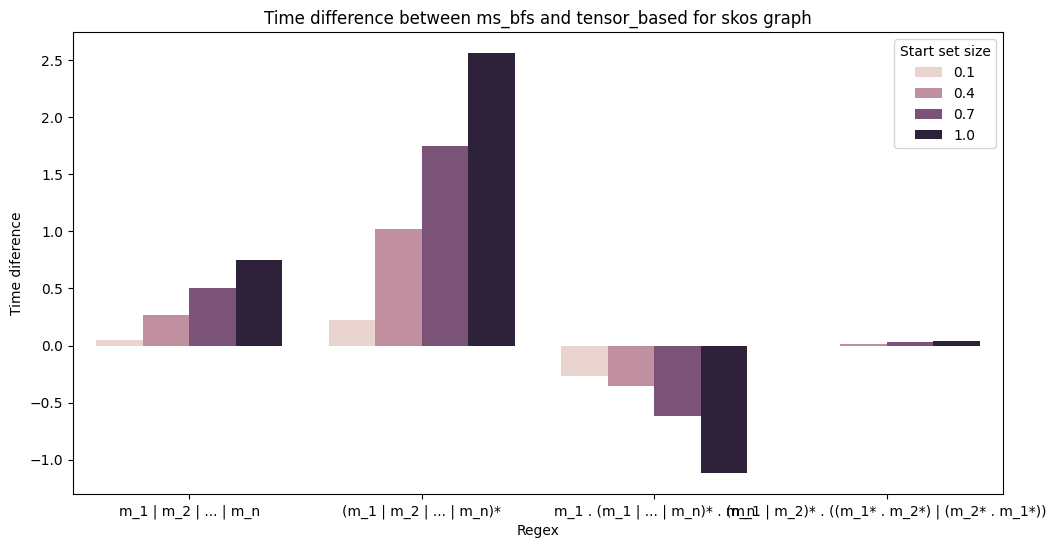

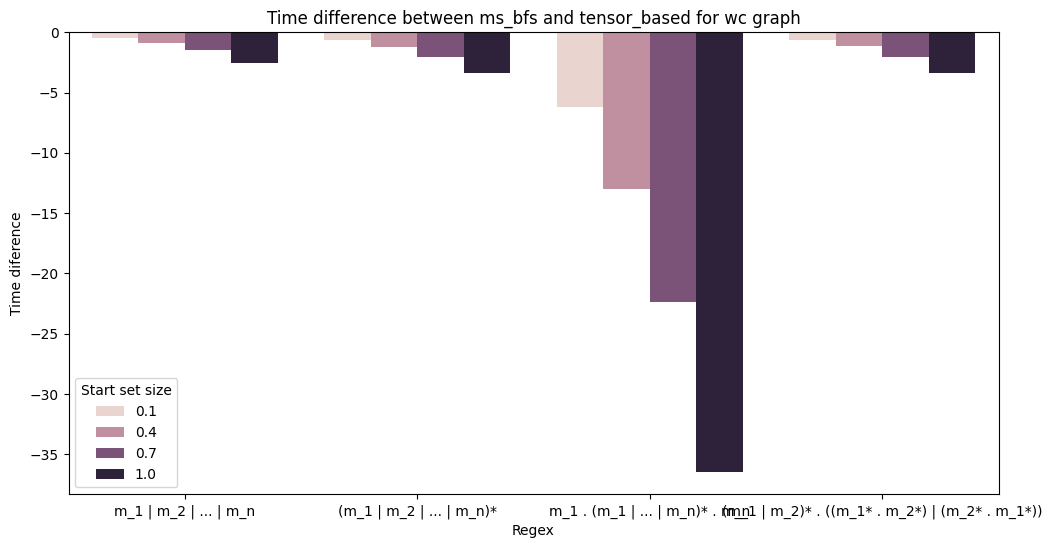

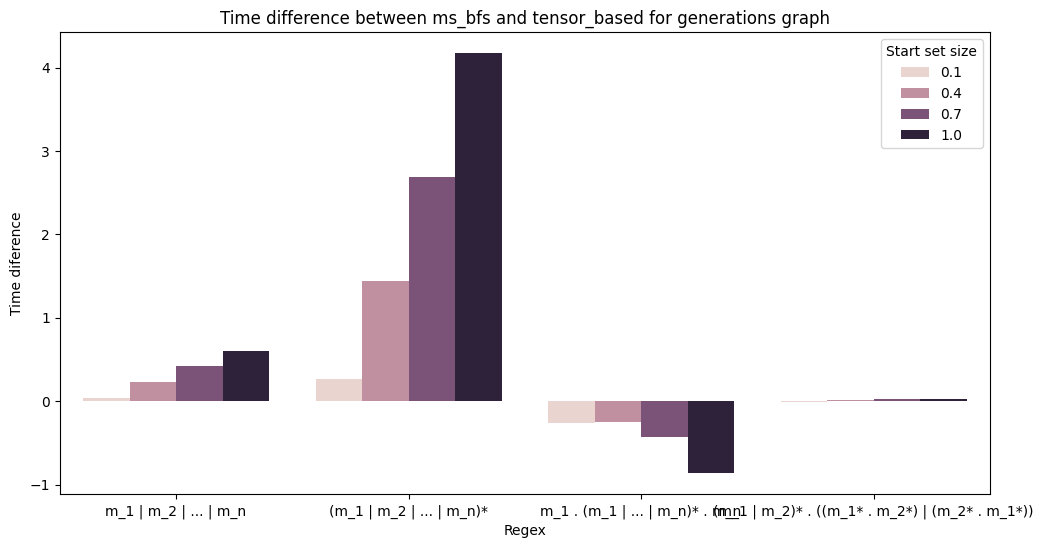

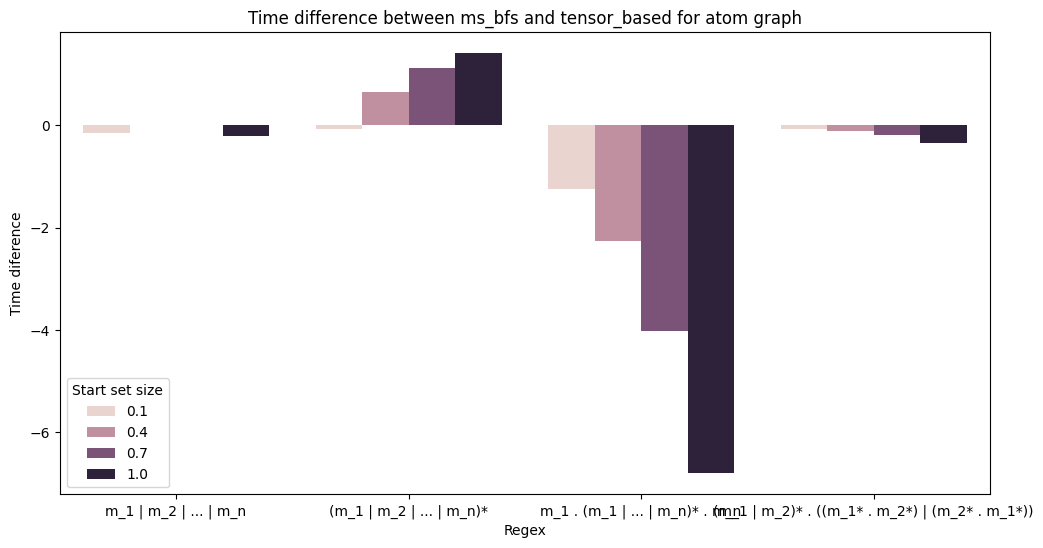

In [64]:
for graph in graph_names:
    mul_plot_df = plot_df[plot_df["graph"] == graph]

    plt.figure(figsize=(12, 6))
    sns.barplot(x="regex", y="time diff", hue="start set size", data=mul_plot_df)
    plt.title(f"Time difference between ms_bfs and tensor_based for {graph} graph")
    plt.xlabel("Regex")
    plt.ylabel("Time diference")
    plt.legend(title="Start set size")
    plt.show()

Посмотрим на процентную разницу во времени работы алгоритмов

/tmp/ipykernel_17979/2324973534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_plot_df["percent time diff"] = (


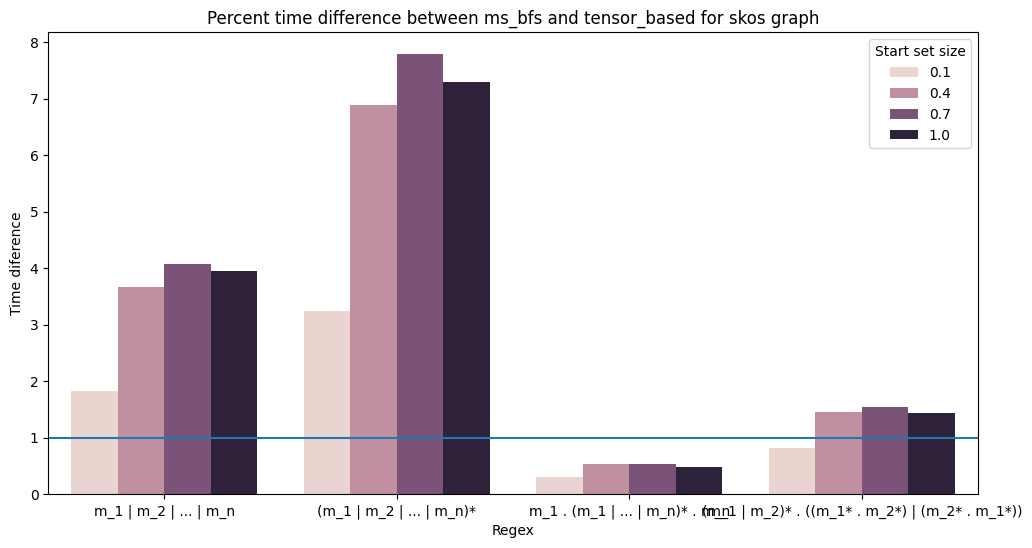

/tmp/ipykernel_17979/2324973534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_plot_df["percent time diff"] = (


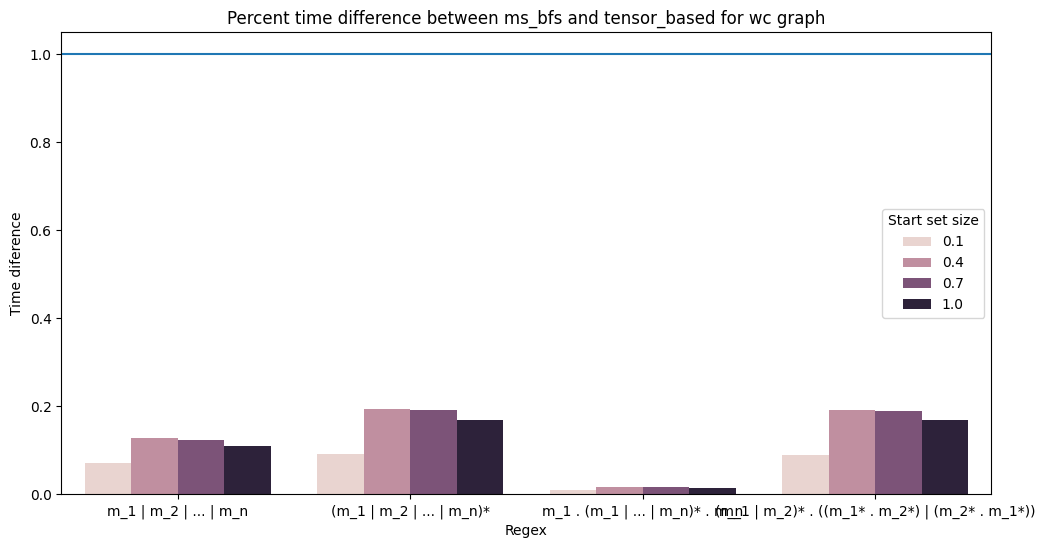

/tmp/ipykernel_17979/2324973534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_plot_df["percent time diff"] = (


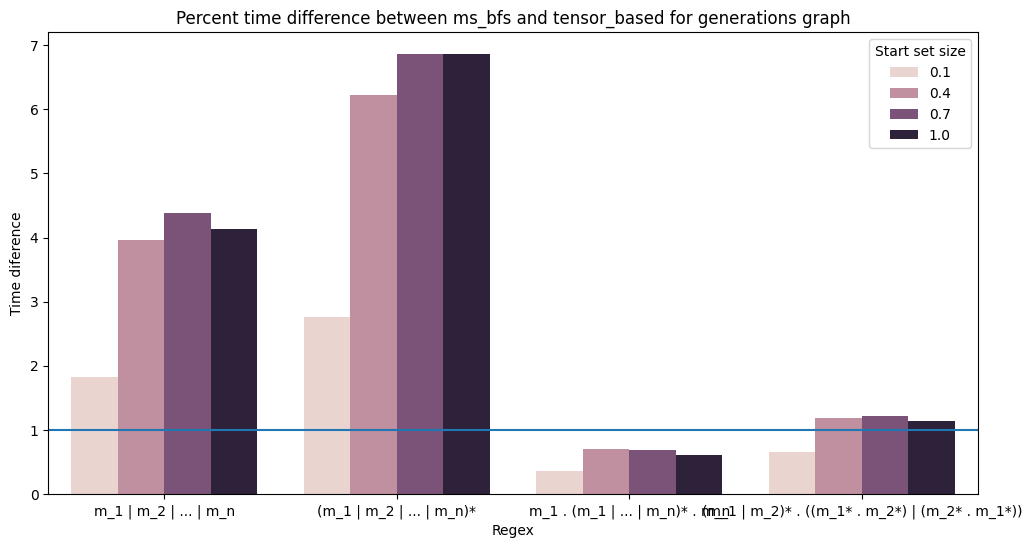

/tmp/ipykernel_17979/2324973534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mul_plot_df["percent time diff"] = (


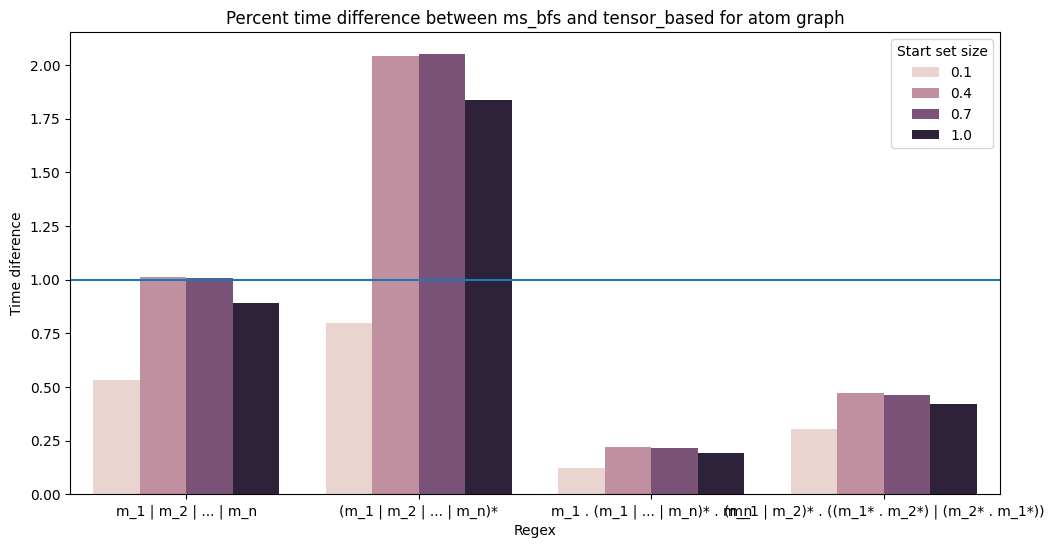

In [75]:
for graph in graph_names:
    mul_plot_df = plot_df[plot_df["graph"] == graph]
    mul_plot_df["percent time diff"] = (
        mul_plot_df["ms_bfs time"] / mul_plot_df["tensor_based time"]
    )

    plt.figure(figsize=(12, 6))
    plot = sns.barplot(
        x="regex", y="percent time diff", hue="start set size", data=mul_plot_df
    )
    plot.axhline(y=1)
    plt.title(
        f"Percent time difference between ms_bfs and tensor_based for {graph} graph"
    )
    plt.xlabel("Regex")
    plt.ylabel("Time diference")
    plt.legend(title="Start set size")
    plt.show()

Как видно из результатов выше, алгоритм `ms_bfs_based_rpq` лучше всего показал себя на графе `wc`. Этот граф обладает наибольшим количеством вершин среди всех расмотренных графов. На небольших графах, таких как `skos` и `generations` и простых регулярных выражениях (чей конечный автомат состоит из 1-2 состояний) в большинстве случаев алгоритм `tensor_based_rpq` оказывался лучше. На регулярном выражении `(m_1 | m_2)* . ((m_1* . m_2*) | (m_2* . m_1*))` и графах `skos` и `generations` видно, что поиск для всех пар вершин следует выбирать, если размер стартового множества равен 0.4 от количества вершин графа.
Выбор алгоритма для заданного стартового множества вершин также зависит от сложности регулярного выражения: для более "простых" регулярных выражений с меньшим количеством состояний `tensor_based_rpq` работает не хуже `ms_bfs_based_rpq`, а для более "сложных" `ms_bfs_based_rpq` оказывается эффективнее.
Таким образом, можно сделать следующие выводы:
1. Для небольших графов (<200 вершин) и несложных регулярных выражений следует выбирать поиск для всех пар для любого количества стартовых вершин
2. Для небольших графов и сложных регулярных выражений, которые сильно "раздувают" тензорное произведение, использовать поиск для всех пар вершин следует начинать при размере стартового мнодества, равного 0.4 от количества еершин графа.
3. Для больших графов (порядка 300 вершин) и сложных регулярных выражений поиск для заданного множества стартовых вершин будет эффективнее.